In [1]:
#ds.to_netcdf("convectProfiles.nc",encoding={'zku':{'zlib':True,'complevel':5},'zka':{'zlib':True,'complevel':5},'precipRate':{'zlib':True,'complevel':5},'bzd':{'zlib':True,'complevel':5},'bcf':{'zlib':True,'complevel':5},'pType':{'zlib':True,'complevel':5},'bsfc':{'zlib':True,'complevel':5},'piah':{'zlib':True,'complevel':5}})

# read data from convectProfiles.nc using netCDF4
import netCDF4 as nc
with nc.Dataset('convectProfiles.nc') as ds:
    zku = ds['zku'][:]
    zka = ds['zka'][:]
    precipRate = ds['precipRate'][:]
    bzd = ds['bzd'][:]
    bcf = ds['bcf'][:]
    pType = ds['pType'][:]
    bsfc = ds['bsfc'][:]
    piah = ds['piah'][:]
    zCorrected=ds['zCorrected'][:]
    binNodes=ds['binNodes'][:]
    dm=ds['dm'][:]
    qv=ds['qv'][:]
    press=ds['press'][:]
    airTemp=ds['airTemp'][:]
    envNodes=ds['envNodes'][:]
    sfcPrecipCMB=ds['sfcPrecipCMB'][:]
    piaSRT=ds['piaSRT'][:]
    piaSRTFlag=ds['piaSRTFlag'][:]
    piaF=ds['piaFinal'][:]
    dm_dpr=ds['dm_dpr'][:]
    zFinal=ds['zFinal'][:]

In [3]:
import libScatter as libSc
import numpy as np
freqs=[10,19,22,35,89,166,183,190]

rho=press*100/(287.058*(airTemp))
qv[qv<1e-3]=1e-3
#print(rho[0,3,3,:])
rhowv=qv*rho*1e-3

rhowvint=np.interp(np.arange(88),envNodes[0,3,3,:],rhowv[0,3,3,:])
pressint=np.interp(np.arange(88),envNodes[0,3,3,:],press[0,3,3,:])
airTempint=np.interp(np.arange(88),envNodes[0,3,3,:],airTemp[0,3,3,:])
idpr=0
if idpr==1:
    rhowvint=np.interp(np.arange(176),2*envNodes[0,3,3,:],rhowv[0,3,3,:])
    pressint=np.interp(np.arange(176),2*envNodes[0,3,3,:],press[0,3,3,:])
    airTempint=np.interp(np.arange(176),2*envNodes[0,3,3,:],airTemp[0,3,3,:])  
kextKaL=[]
freqKa=35.5
for i in range(rhowvint.shape[0]):
    ireturn=1
    kextKa=libSc.gasabsr98(freqKa,airTempint[i],rhowvint[i],pressint[i],ireturn)
    kextKaL.append(kextKa[0]+kextKa[1])
#print(kextKaL)
kextKaL=np.array(kextKaL)

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from simCMB import simulateZKa
import simCMB
#reload (simulateZKa)
import importlib
importlib.reload(simCMB)

a=np.nonzero(precipRate[:,3,3,-1]>10)
print(zku.shape)
print(len(a[0]))
#print(precipRate[a[0],3,3,-1])
for i in range(-1,-2):
    for j in range(-1,2):
        plt.plot(zku[a[0][0],3+i,3+j,:],range(176),'*')
dm_factor=0.998 # vs 0.8 improved the agreement with the observed Z-Ka
import lkTables
import lkTables as lkT
lkTables_=lkT.scattTables()
#print(lkTables_.dms[0:253])
zka12_nomL=[]
import tqdm
piaL=[]
msFlag=1
dr=0.25
dm_factor=0.7
zKuSimL=[]
zKaSimL=[]
zKaSimMsL=[]
binNodesDPR=binNodes*2
binNodesDPR[:,:,:,-1]+=1
bsfcCMB=bsfc//2
pRateL=[]
for i0 in tqdm.tqdm(range(len(a[0]))):
    zKaSim,zkaSfc,kexttot,salbtot,asym1D,\
        zKa_true,zms,piaKa2d,piaKu2d,zKuSim,pRate=simCMB.simulateZKa(binNodes[a[0][i0],:,:].data,zCorrected[a[0][i0],:,:].data,dm[a[0][i0],:,:].data,dm_factor,lkTables_,pType[a[0][i0],:,:].data,kextKaL,libSc,bsfcCMB[a[0][i0],:,:,:].data,msFlag,dr)
    zka12_nomL.append([zKaSim[3,3,binNodes[a[0][i0],3,3,1]],zka[a[0][i0],3,3,binNodes[a[0][i0],3,3,1]*2],\
                   zms[3,3,binNodes[a[0][i0],3,3,1]]])
    zKuSimL.append(zKuSim)
    zKaSimL.append(zKaSim)
    zKaSimMsL.append(zms)
    pRateL.append(pRate)
    if piaSRTFlag[a[0][i0],3,3,0] == 1 or piaSRTFlag[a[0][i0],3,3,0] == 2:
        piaL.append([piaSRT[a[0][i0],3,3,0],piaKu2d[3,3],piaF[a[0][i0],3,3,0]])
    
    #break


(33739, 7, 7, 176)
2729


100%|██████████| 2729/2729 [04:02<00:00, 11.25it/s]


In [89]:
cfadKu=np.zeros((45,40))
cfadKa=np.zeros((45,40))
pRateL=np.array(pRateL)
cfadRate=np.zeros((45,40))
icount=0
for z1,z2 in zip(zku[a[0]],zKuSimL):
    #print(z1.shape,z2.shape)
    #print(binNodesDPR[a[0][icount],3,3,:])
    for k1 in range(binNodes[a[0][icount],3,3,0],binNodes[a[0][icount],3,3,4]):
        #print(k1,z1[3,3,k1],z2[3,3,k1])
        if pRateL[icount][3,3,k1]>0.01:
            ik=70-binNodes[a[0][icount],3,3,1]+k1-43
            ipr=int(np.log10(1+pRateL[icount][3,3,k1]/0.01)*9)
            if ik>=0 and ik<45 and ipr>=0 and ipr<40:
                cfadRate[ik,ipr]+=1
        if z1[3,3,2*k1]>-99 and z1[3,3,2*k1+1]>-99 and z2[3,3,k1]>-99:
            zm=10*np.log10(0.5*(10**(0.1*z1[3,3,2*k1])+10**(0.1*z1[3,3,2*k1+1])))
            dz=-(zm-z2[3,3,k1])
            ik=70-binNodes[a[0][icount],3,3,1]+k1-43
            #print(dz,ik)
            idiff=int(dz/0.25)+20
            #print(dz,ik,idiff)
            if ik>=0 and ik<45 and idiff>=0 and idiff<40:
                cfadKu[ik,idiff]+=1
    #break
    icount+=1

#cfadKu=np.zeros((90,40))
icount=0
for z1,z2 in zip(zka[a[0]],zKaSimMsL):
    #print(z1.shape,z2.shape)
    #print(binNodesDPR[a[0][icount],3,3,:])
    for k1 in range(binNodes[a[0][icount],3,3,0],binNodes[a[0][icount],3,3,4]):
        #print(k1,z1[3,3,k1],z2[3,3,k1])
        if z1[3,3,2*k1]>-0 and z1[3,3,2*k1+1]>-99 and z2[3,3,k1]>-0:
           
            zm=10*np.log10(0.5*(10**(0.1*z1[3,3,2*k1])+10**(0.1*z1[3,3,2*k1+1])))
            dz=-(zm-z2[3,3,k1])
            ik=70-binNodes[a[0][icount],3,3,1]+k1-43
            #print(dz,ik)
            idiff=int(dz/0.5)+20
            #print(dz,ik,idiff)
            if ik>=0 and ik<45 and idiff>=0 and idiff<40:
                cfadKa[ik,idiff]+=1
    #break
    icount+=1


IndexError: index 0 is out of bounds for axis 0 with size 0

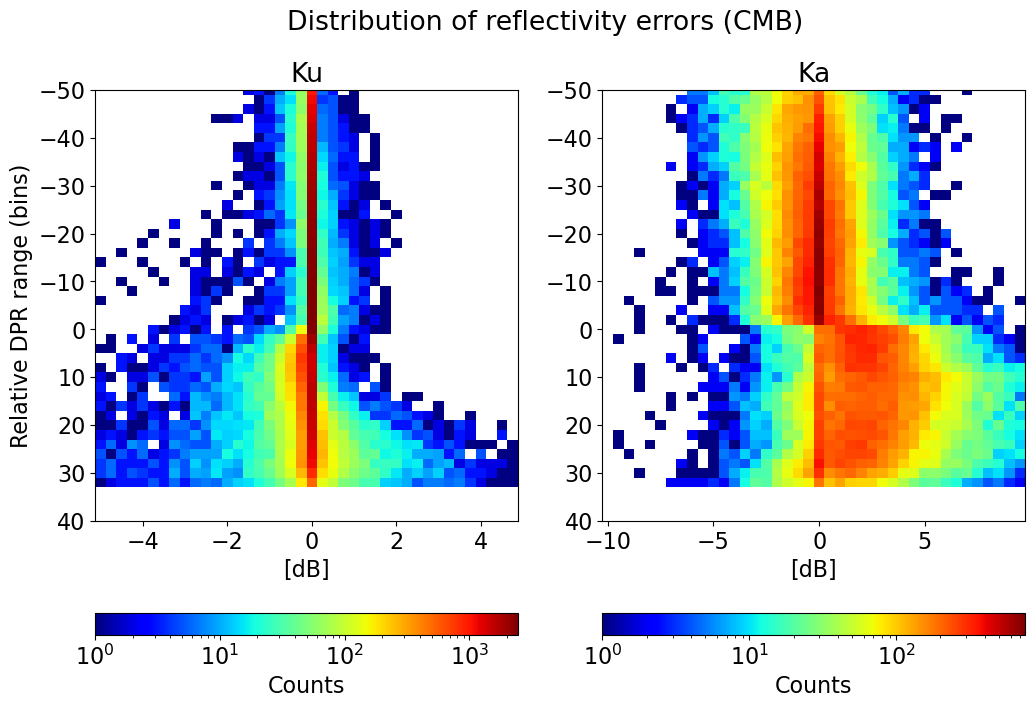

In [47]:

#print(cfad.max())
import matplotlib
# increase font using rc
matplotlib.rcParams.update({'font.size': 16})

plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.pcolormesh(-5+np.arange(40)*0.25,(np.arange(45)-28)*2,cfadKu,cmap='jet',norm=matplotlib.colors.LogNorm())
plt.ylim(40,-50)
plt.ylabel('Relative DPR range (bins)')
plt.xlabel('[dB]')
plt.title('Ku')
plt.colorbar(orientation='horizontal',label='Counts')
plt.subplot(1,2,2)
plt.pcolormesh(-10+np.arange(40)*0.5,(np.arange(45)-28)*2,cfadKa,cmap='jet',norm=matplotlib.colors.LogNorm())
plt.ylim(40,-50)
#plt.ylabel('Relative DPR range (bins)')
plt.xlabel('[dB]')
plt.title('Ka')
plt.colorbar(orientation='horizontal',label='Counts')
#plt.tight_layout()
plt.suptitle('Distribution of reflectivity errors (CMB)')
plt.savefig('cfadKuKa_CMB_f10.05.png',dpi=300)



In [86]:
print(lkT.scattTables.rainRate[0:100])

[0.00385137 0.00401948 0.00420501 0.00439208 0.00458075 0.00477063
 0.00496257 0.00515547 0.00535078 0.00555853 0.00580655 0.00605556
 0.00630808 0.00657377 0.00688115 0.007175   0.00743542 0.00771695
 0.00803475 0.00838064 0.00875699 0.0091369  0.009519   0.00990576
 0.01029379 0.01074225 0.01119315 0.01164977 0.01213596 0.012658
 0.01318451 0.01371429 0.01430952 0.01490773 0.01551159 0.01616259
 0.01683548 0.01751787 0.01823249 0.01898816 0.01975038 0.02055323
 0.02145762 0.02236893 0.02328519 0.02421111 0.0252378  0.02631247
 0.02739648 0.02854066 0.02971167 0.03089222 0.03220253 0.03354517
 0.0348946  0.03633516 0.03787493 0.03948177 0.04109941 0.04279911
 0.04456145 0.04638872 0.04829421 0.050284   0.05238696 0.05456918
 0.05677619 0.05915714 0.06162379 0.06416699 0.06681377 0.06960265
 0.07241722 0.07547291 0.07858047 0.08179727 0.08518488 0.08872683
 0.09238537 0.09615684 0.10017844 0.10427357 0.10857112 0.11305454
 0.11769265 0.12254    0.1275955  0.13287218 0.13834962 0.144085

0.1796014724133812
0.7228613044699184
3.53376492485404 4.920568816701605 6.861430295512208


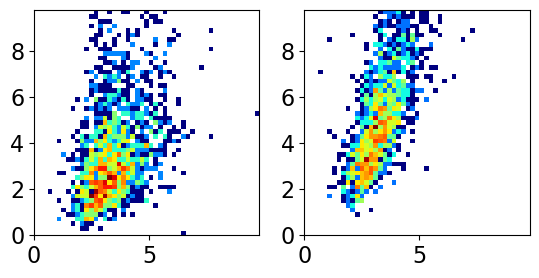

In [40]:
import matplotlib
piaL=np.array(piaL)
print(np.corrcoef(piaL[:,0],piaL[:,1])[0,1])
print(np.corrcoef(piaL[:,0],piaL[:,2])[0,1])
print(piaL[:,0].mean(),piaL[:,1].mean(),piaL[:,2].mean())
ax1=plt.subplot(121)
h2p=plt.hist2d(piaL[:,0],piaL[:,1],bins=np.arange(50)*0.2,norm=matplotlib.colors.LogNorm(),cmap='jet')
ax1.set_aspect('equal')
ax2=plt.subplot(122)
h2p=plt.hist2d(piaL[:,0],piaL[:,2],bins=np.arange(50)*0.2,norm=matplotlib.colors.LogNorm(),cmap='jet')
ax2.set_aspect('equal')

In [6]:
#print(lkTables_.asymR[0:253,3])
n1=binNodes[a[0][i0],3,3,1]
print(zKaSim[3,3,n1-10:n1])
print(zms[3,3,n1-10:n1])
print(zkaSfc[3,3]-zka[a[0][i0],3,3,n1])


[20.70061623 21.29144205 22.44904649 22.42621111 23.97026601 25.93309432
 26.6529506  27.96780739 27.59064979 28.56193791]
[20.76476669 21.35083771 22.50295639 22.49047279 24.02855873 25.99346542
 26.73828506 28.07870483 27.76576614 28.76931763]
7.189746396168253


In [20]:
noms=0
alt=400
theta=0.5
nonorm=1
dr=0.25
n1=binNodes[a[0][0],3,3,-1]
print(n1)
print(kexttot[3,3,:n1].shape,salbtot[3,3,:n1].shape,asym1D[3,3,:n1,3].shape,\
                        zKa_true[3,3,:n1].shape)
print(kexttot[3,3,n1-10:n1])
print(salbtot[3,3,n1-10:n1])
print(asym1D[3,3,n1-10:n1,3])
zms = libSc.multiscatterf(kexttot[3,3,:n1],salbtot[3,3,:n1],asym1D[3,3,:n1,3],\
                        zKa_true[3,3,:n1],dr,noms,alt,theta,freqKa,nonorm)
#print(zms)
#print(zKaSim[3,3,:binNodes[a[0][0],3,3,-1]])

83
(83,) (83,) (83,) (83,)
[0.46204982 0.51019339 0.6585391  0.63870592 0.65916437 0.74983024
 0.79076153 0.84597012 0.89476271 0.98229987]
[0.18608459 0.20960098 0.28232885 0.27606573 0.28598559 0.334977
 0.35594245 0.3876661  0.41548548 0.46530352]
[1.58991408 1.82151103 2.46025991 2.6277554  2.71541381 3.40946484
 3.63619065 4.26735115 4.84587526 5.85604858]


In [ ]:
#plt.plot(zka[a[0][0],3,3,:],range(176))
#plt.xlim(0,50)
#plt.ylim(175,100)
plt.figure()
plt.subplot(121)
plt.pcolormesh(zku[a[0][i0],:,3,:].T,vmin=0,vmax=50,cmap='jet')
plt.ylim(175,100)
plt.subplot(122)
plt.pcolormesh(zka[a[0][i0],:,3,:].T,vmin=0,vmax=50,cmap='jet')
plt.plot(np.arange(7)+0.5,bzd[a[0][i0],3,:])
plt.plot(np.arange(7)+0.5,bcf[a[0][i0],3,:])
plt.ylim(175,100)

plt.figure()
plt.subplot(121)
plt.subplot(122)
plt.pcolormesh(zKaSim[:,3,:].T,vmin=0,vmax=50,cmap='jet')
plt.ylim(87,50)

[[1.         0.70704603]
 [0.70704603 1.        ]]
[[1.         0.86364067]
 [0.86364067 1.        ]]


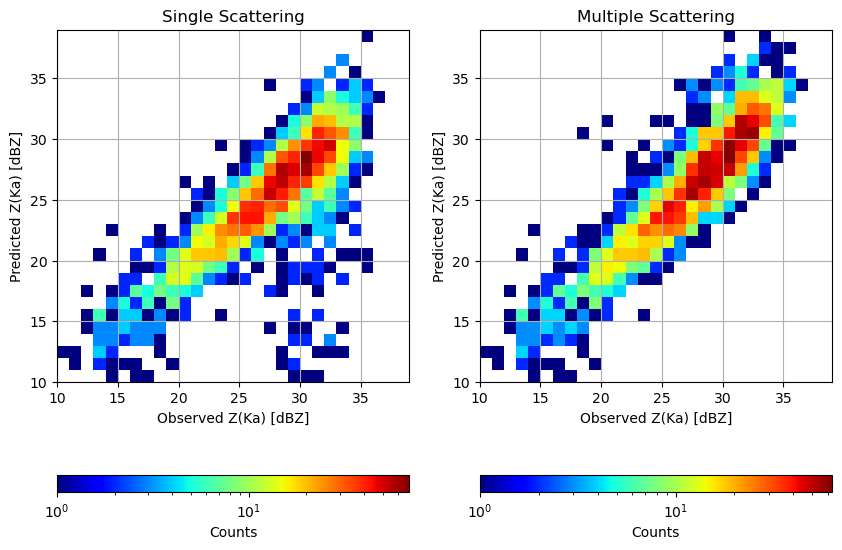

In [17]:
zka12_nomL=np.array(zka12_nomL)
#zka12L_nom=np.array(zka12L_nom)
import matplotlib.colors as colors 
from matplotlib.colors import LogNorm
plt.figure(figsize=(10,8))
ax=plt.subplot(121)
zka12_nomL[zka12_nomL<-10]=-10
h2=plt.hist2d(zka12_nomL[:,1],zka12_nomL[:,0],bins=np.arange(30)+10,norm=LogNorm(),cmap='jet')
#zka12L[zka12L<-10]=-10
#
plt.grid()
#zka12L.min(axis=0)
ax.set_aspect('equal')
plt.xlabel('Observed Z(Ka) [dBZ]')
plt.ylabel('Predicted Z(Ka) [dBZ]')
plt.title('Single Scattering')
plt.colorbar(h2[3],orientation='horizontal',label='Counts')
ax=plt.subplot(122)
h2=plt.hist2d(zka12_nomL[:,1],zka12_nomL[:,2],bins=np.arange(30)+10,norm=LogNorm(),cmap='jet')
#zka12L[zka12L<-10]=-10
#zka12L.min(axis=0)
ax.set_aspect('equal')
print(np.corrcoef(zka12_nomL[:,0],zka12_nomL[:,1]))
print(np.corrcoef(zka12_nomL[:,2],zka12_nomL[:,1]))
plt.xlabel('Observed Z(Ka) [dBZ]')
plt.ylabel('Predicted Z(Ka) [dBZ]')
plt.title('Multiple Scattering')

plt.grid()
plt.colorbar(h2[3],orientation='horizontal',label='Counts')
plt.savefig('simulatedZKaConvection_nominal_2.png',dpi=300)

In [35]:
from bisectm import bisectm
ind=bisectm(lkTables_.dms.data,253,0.79)

In [4]:
graupAttCoeffs=np.array([0.99309693, 10.0**(-5.28837939)])
rainAttCoeffs=np.array([0.69680178, 10.0**(-3.14072835)])

def get_alpha_bet(graupAttCoeffs,rainAttCoeffs,nodes):
    alpha=np.zeros(176)
    beta=np.zeros(176)
    alpha=np.interp(np.arange(176),[0,nodes[0],nodes[1],175],[graupAttCoeffs[1],graupAttCoeffs[1],\
                                                             rainAttCoeffs[1],rainAttCoeffs[1]])
    beta=np.interp(np.arange(176),[0,nodes[0],nodes[1],175],[graupAttCoeffs[0],graupAttCoeffs[0],\
                                                                rainAttCoeffs[0],rainAttCoeffs[0]])
    return alpha,beta
def hbConv(zKum,dn,alpha,beta,dr):
    q=0.2*np.log(10)
    zeta=q*beta*dn**(1-beta)*alpha*10**(0.1*zKum*beta)*dr
    zetaSum=zeta.cumsum()[-1]
    if zetaSum>0.995:
        f=0.995/zetaSum
    else:
        f=1
    zc=zKum-10/beta*np.log10(1-f*zeta.cumsum())
    pia=-10/beta*np.log10(1-f*zeta.cumsum()[-1])
    return zc,pia

def hbConvWithPIA(zKum,alpha,beta,pia,dr):
    dn=1.0
    q=0.2*np.log(10)
    zeta=q*beta*dn**(1-beta)*alpha*10**(0.1*zKum*beta)*dr
    zetaSum=zeta.cumsum()[-1]
    
    f=(1-10**(-0.1*beta[-1]*pia))/zetaSum
    zc=zKum-10/beta*np.log10(1-f*zeta.cumsum())
    pia_out=-10/beta[-1]*np.log10(1-f*zeta.cumsum()[-1])
    return zc,pia_out,f

In [5]:
#
import numpy as np
import time
from datetime import date
import matplotlib.pyplot as plt
import sys
sys.path.insert(0,"/Users/mgrecu/GPM/ORO_old/retr")
import lkTables
from radarRetrSubs import *

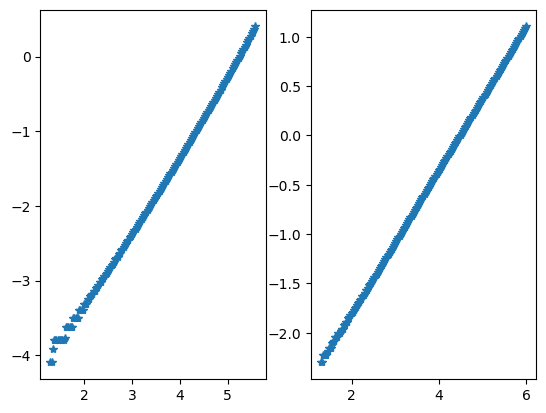

In [7]:
#print(dir(lkTables))
#print(dir(lkTables.scattTables))
#a=np.nonzero(lkTables.scattTables.attKuG[:]>0)
#attKuGCoeffs=np.polyfit(lkTables.scattTables.zKuG[a]/10,np.log10(lkTables.scattTables.attKuG[a]),1)

#print(attKuGCoeffs)
#print(np.log10(lkTables.scattTables.attKuG[50:]))
#print(lkTables.scattTables.zKuG[50:]/10)

plt.subplot(121)    
plt.plot(lkTables.scattTables.zKuG[100:]/10,np.log10(lkTables.scattTables.attKuG[100:]),'*')
#plt.plot(lkTables.scattTables.zKuG[100:]/10,np.polyval(attKuGCoeffs,lkTables.scattTables.zKuG[100:]/10))

#a=np.nonzero(lkTables.scattTables.attKuR[:]>0)
#attKuRCoeffs=np.polyfit(lkTables.scattTables.zKuR[a]/10,np.log10(lkTables.scattTables.attKuR[a]),1)
#print(attKuRCoeffs)

plt.subplot(122)
plt.plot(lkTables.scattTables.zKuR[100:]/10,np.log10(lkTables.scattTables.attKuR[100:]),'*')
#plt.plot(lkTables.scattTables.zKuR[100:]/10,np.polyval(attKuRCoeffs,lkTables.scattTables.zKuR[100:]/10))




In [17]:
i0=95
def get_alpha_bet(graupCoeffs,rainCoeffs,nodes):
    alpha=np.zeros(176)
    beta=np.zeros(176)
    alpha=np.interp(np.arange(176),[0,nodes[0],nodes[1],175],[graupCoeffs[1],graupCoeffs[1],\
                                                             rainCoeffs[1],rainCoeffs[1]])
    beta=np.interp(np.arange(176),[0,nodes[0],nodes[1],175],[graupCoeffs[0],graupCoeffs[0],\
                                                                rainCoeffs[0],rainCoeffs[0]])
    return alpha,beta

rateL=[]
def profiling(zku,zka,a,i0,bzd,bcf):
    zm=zku[a[0][i0],3,3,:]
    zm_ka=zka[a[0][i0],3,3,:]
    zm_ka[zm_ka<0]=0
    zm[zm<0]=0
    #plt.plot(zm,range(176),'*')
    #plt.plot(zm_ka,range(176),'*')
    #plt.ylim(175,80)
    nodes=[bzd[a[0][0],3,3],bzd[a[0][0],3,3]+4]
    #print(nodes)

    alpha,beta=get_alpha_bet(graupAttCoeffs,rainAttCoeffs,nodes)    
    bcf1=bcf[a[0][i0],3,3]
    piaKuH=piah[a[0][i0],3,3,0]
    dr=0.125
    zc,pia_out,f=hbConvWithPIA(zm[:bcf1],alpha[:bcf1],beta[:bcf1],piaKuH,dr)

    #plt.plot(zc,range(bcf1),'-')
    #print(pia_out,piaKuH,f)
    dn=np.log10(f)/(1-rainAttCoeffs[1])
    #print(dn,piaKuH)
    dnw=np.zeros(176)+dn
    zkaRet,zka_true,piaKaG,pRateG,kextKaG,salbKaG,asymKaG,dmG,piaKuG=getZKa_graup(dnw[:nodes[1]]+0.25,zc[:nodes[1]],lkTables.scattTables,dr)
    dbin=0
    zkaRetRain,zka_true,piaKaR,pRateR,kextKaR,\
    asymKaR,salbKaR,dmR,piaKuR=getZKa_rain(dnw[nodes[1]:bcf1]-0.5,zc[nodes[1]:bcf1],lkTables.scattTables,dr,\
                                           piaKaG,piaKuG,dbin)
    return pRateR[-1],piaKuR
piaKuL=[]
for i in range(0,len(a[0])):
    pRateSfc,piaKu=profiling(zku,zka,a,i,bzd,bcf)
    rateL.append(pRateSfc)
    piaKuL.append(piaKu)
    #print(i,rateL[-1])
#plt.plot(zkaRet,range(nodes[1]),'-')
#plt.plot(zkaRetRain,range(nodes[1],bcf1),'-')
#plt.xlim(0,50)
#print(piaKaG,piaKaR)

[[1.         0.12867209]
 [0.12867209 1.        ]]
11.132817986845643 106.94715
3.054962656778621 4.229884


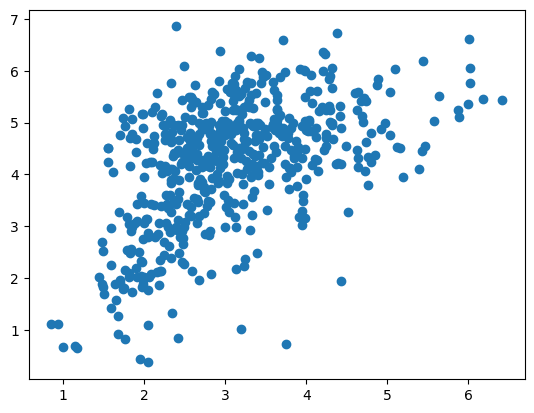

In [21]:
print(np.corrcoef(rateL,precipRate[a[0],3,3,-1]))
print(np.mean(rateL),np.mean(precipRate[a[0],3,3,-1]))
plt.scatter(piaKuL,piah[a[0],3,3,0])
print(np.mean(piaKuL),np.mean(piah[a[0],3,3,0]))
#plt.scatter(rateL,precipRate[a[0],3,3,-1])